# **CIFAR 10**
A FFNN (Feed Forward Neural Network) and CNN (Convolutional Nerual Network)  and Residual network have been modeled.

## Import required packages

In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 

## Defining our Transforms


In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

## Gathering the train and test data

In [3]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform_train)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Defining our Train, Valid and Test Dataloaders

In [5]:
num_workers=0
batch_size=50
valid_size=0.2
train_length = len(train_data)
indices=list(range(len(train_data)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
valid_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)

In [7]:
dataiter=iter(train_loader)
# images,labels=dataiter.next()
images, labels = next(dataiter)
images,labels,images.shape,labels.shape

(tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.6549, -0.6235, -1.0000],
           [ 0.0510, -0.0118, -0.1843,  ..., -0.6314, -0.6235, -1.0000],
           [ 0.0275,  0.0196, -0.1059,  ..., -0.6314, -0.6706, -1.0000],
           ...,
           [-1.0000,  0.0353,  0.0588,  ...,  0.0588,  0.0039, -0.0353],
           [-1.0000,  0.0667,  0.1216,  ...,  0.0510,  0.0039, -0.0353],
           [-1.0000,  0.0824,  0.0745,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -0.5137, -0.4824, -1.0000],
           [ 0.0353, -0.1843, -0.3647,  ..., -0.4980, -0.4902, -1.0000],
           [-0.0353, -0.1451, -0.2941,  ..., -0.4902, -0.5373, -1.0000],
           ...,
           [-1.0000, -0.0980, -0.0824,  ...,  0.0510,  0.0039, -0.0196],
           [-1.0000, -0.0118,  0.0824,  ...,  0.0745,  0.0275, -0.0196],
           [-1.0000,  0.0980,  0.1373,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -0.6314, -0.5922, -1.0000],
           [-

## Visualizing a Training batch

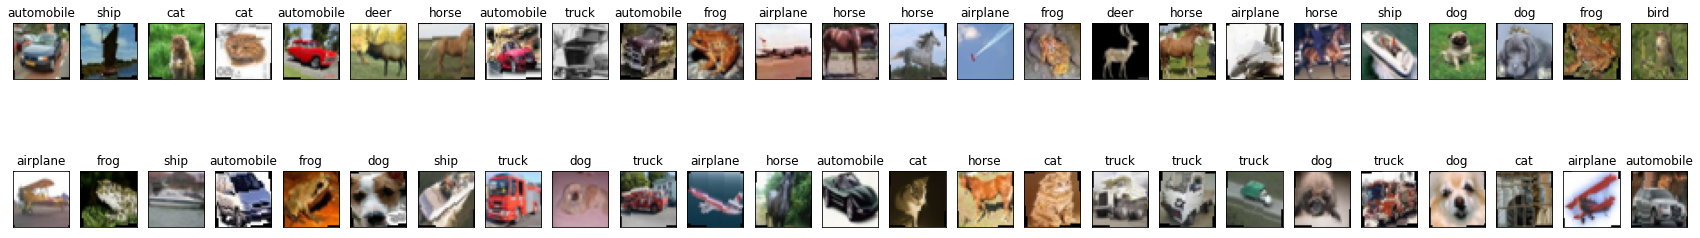

In [9]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(batch_size):
    ax=fig.add_subplot(2,int(batch_size/2),idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Defining our Neural Net Architecture

In [11]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(3*32*32,2048)
        self.fc2=nn.Linear(2048,1024)
        self.fc3=nn.Linear(1024,512)
        self.fc4=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        x=x.view(-1,32*32*3)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=self.dropout(F.relu(self.fc4(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
    def __init__(self):
        super(convNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.b1=nn.BatchNorm2d(16)
        self.b2=nn.BatchNorm2d(64)
        self.b3=nn.BatchNorm2d(256)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)  

        self.dropout=nn.Dropout(0.1)
        self.fc1=nn.Linear(256,128)
        self.fc2=nn.Linear(128,64)
        self.out=nn.Linear(64,10)


    def forward(self,x):
        # Input --> 3 X 32 X 32 
        x=self.pool(F.relu(self.b1(self.conv1(x))))
        # Output --> after conv --> 16 X 32 X 32  --> Max Pool  -->16 X 16 X 16
        x=self.pool(F.relu(self.conv2(x)))
        # Output --> after conv --> 32 X 16 X 16 --> 32 X 8 X 8
        x=self.pool(F.relu(self.b2(self.conv3(x))))
        # Output --> after conv --> 64 X 8 X 8 --> Max Pool --> 64 X 4 X 4
        x=self.pool(F.relu(self.conv4(x)))
        # Output --> after conv --> 128 X 4 X 4 --> Max Pool --> 128 X 2 X 2
        x=self.pool(F.relu(self.b3(self.conv5(x))))
        # Output --> after conv --> 256 X 2 X 2 --> Max Pool --> 256 X 1 X 1
        x=x.view(-1,256)
        # Output --> 1 X 256
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)   
        return x


In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels=3
        num_classes=10
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [12]:
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1=FNet()
model_2=convNet()
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
    model_1.cuda()
    model_2.cuda()
print(model_1,'\n\n\n\n',model_2,'\n','On GPU : ',use_cuda and torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
) 



 convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [21]:
model_3 = ResNet9()
model_3.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
    model_3.cuda()
print(model_3,'\n','On GPU : ',use_cuda and torch.cuda.is_available())

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Defining our Loss Function

In [13]:
criterion=nn.CrossEntropyLoss()

## Training and Validation Phase

In [14]:
def trainNet(model,lr,trainer,validater):
    optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    acc_keeper={'train':[],'valid':[]}
    train_class_correct = list(0. for i in range(10))
    valid_class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        train_correct=0.0
        valid_correct=0.0
        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in trainer:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            _, pred = torch.max(output, 1)
            train_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                train_class_correct[label] += train_correct[idx].item()
                class_total[label] += 1

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in validater:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()
            _, pred = torch.max(output, 1)
            valid_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                valid_class_correct[label] += valid_correct[idx].item()
                class_total[label] += 1

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(trainer)
        valid_loss = valid_loss/len(validater)

        # Calculating loss over entire batch size for every epoch
        train_acc=float(100. * np.sum(train_class_correct) / np.sum(class_total))
        valid_acc=float(100. * np.sum(valid_class_correct) / np.sum(class_total))

        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        # saving acc values
        acc_keeper['train'].append(train_acc)
        acc_keeper['valid'].append(valid_acc)

        print(f"Epoch : {epoch+1}")
        print(f"Training Loss : {train_loss}\tValidation Loss : {valid_loss}")

        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss

        print(f"Training Accuracy : {train_acc}\tValidation Accuracy : {valid_acc}\n\n")

    return(loss_keeper,acc_keeper)

In [15]:
m1_loss,m1_acc=trainNet(model_1,0.01,train_loader,valid_loader)

Epoch : 1
Training Loss : 1.8201166743040085	Validation Loss : 1.6435644924640656
Validation loss decreased from : inf ----> 1.6435644924640656 ----> Saving Model.......
Training Accuracy : 27.348	Validation Accuracy : 8.388


Epoch : 2
Training Loss : 1.6311792708933353	Validation Loss : 1.545806241631508
Validation loss decreased from : 1.6435644924640656 ----> 1.545806241631508 ----> Saving Model.......
Training Accuracy : 30.465	Validation Accuracy : 8.751


Epoch : 3
Training Loss : 1.5484181827306747	Validation Loss : 1.5046631282567977
Validation loss decreased from : 1.545806241631508 ----> 1.5046631282567977 ----> Saving Model.......
Training Accuracy : 32.30133333333333	Validation Accuracy : 8.948666666666666


Epoch : 4
Training Loss : 1.4932466335594654	Validation Loss : 1.462904881834984
Validation loss decreased from : 1.5046631282567977 ----> 1.462904881834984 ----> Saving Model.......
Training Accuracy : 33.6055	Validation Accuracy : 9.106


Epoch : 5
Training Loss : 1.

In [16]:
m1_loss,m1_acc


({'train': [1.8201166743040085,
   1.6311792708933353,
   1.5484181827306747,
   1.4932466335594654,
   1.4504743504524231,
   1.4149419502913951,
   1.385702382028103,
   1.3584157593548298,
   1.335192389190197,
   1.3117419262230396,
   1.2900604686886072,
   1.271563170850277,
   1.2540697844326496,
   1.2333627925813198,
   1.2177803687006235,
   1.2071731343865395,
   1.1926497368514537,
   1.1738610698282719,
   1.15594907194376,
   1.1423597948998212,
   1.133367603123188,
   1.1171400397270919,
   1.1091240929067134,
   1.1026201107352973,
   1.07913295827806,
   1.075032437592745,
   1.0590090595930814,
   1.0444971668720244,
   1.0339349573105574,
   1.0239324951916933,
   1.0232734660804272,
   1.0066340139508247,
   0.9942043258994818,
   0.9848306781053543,
   0.9809273431450128,
   0.9679647453874349,
   0.9656342052668333,
   0.9556498689949513,
   0.9372200553119182,
   0.9316282645240426,
   0.9208365136384964,
   0.9119610584527255,
   0.9002940917015075,
   0.892765

In [17]:
m2_loss,m2_acc=trainNet(model_2,0.01,train_loader,valid_loader)

Epoch : 1
Training Loss : 1.5423530715703964	Validation Loss : 1.3578344011306762
Validation loss decreased from : inf ----> 1.3578344011306762 ----> Saving Model.......
Training Accuracy : 34.666	Validation Accuracy : 10.084


Epoch : 2
Training Loss : 1.2391003039479256	Validation Loss : 1.3326263070106505
Validation loss decreased from : 1.3578344011306762 ----> 1.3326263070106505 ----> Saving Model.......
Training Accuracy : 39.536	Validation Accuracy : 10.447


Epoch : 3
Training Loss : 1.0984161890298128	Validation Loss : 1.117930455505848
Validation loss decreased from : 1.3326263070106505 ----> 1.117930455505848 ----> Saving Model.......
Training Accuracy : 42.675333333333334	Validation Accuracy : 10.994666666666667


Epoch : 4
Training Loss : 1.0010901203751563	Validation Loss : 1.0287659084796905
Validation loss decreased from : 1.117930455505848 ----> 1.0287659084796905 ----> Saving Model.......
Training Accuracy : 45.01	Validation Accuracy : 11.4365


Epoch : 5
Training Los

In [18]:
m2_loss,m2_acc


({'train': [1.5423530715703964,
   1.2391003039479256,
   1.0984161890298128,
   1.0010901203751563,
   0.9236911830306053,
   0.8611545815691352,
   0.8259162393584848,
   0.7805161547288298,
   0.748472413867712,
   0.7194270992279053,
   0.696161389797926,
   0.6750451910495758,
   0.6518635440245271,
   0.6323768219351769,
   0.6129736376553774,
   0.591761181820184,
   0.5808844328671694,
   0.5671475049480796,
   0.5510016721859574,
   0.5387372785620391,
   0.52542370531708,
   0.5128945802524686,
   0.5013266139291227,
   0.49122721690684557,
   0.4837501483783126,
   0.4735202021151781,
   0.46198502644896505,
   0.4574748842045665,
   0.44356093974784017,
   0.4323735009878874,
   0.4274511804804206,
   0.4155835606809706,
   0.4074323547445238,
   0.40152785073965785,
   0.39743276199325916,
   0.3886279347073287,
   0.3818960578646511,
   0.3734587913006544,
   0.3676881737075746,
   0.3568278473522514,
   0.3524013118911535,
   0.35449690813198687,
   0.33791285964660345,


In [22]:
m3_loss,m3_acc=trainNet(model_3,0.01,train_loader,valid_loader)

Epoch : 1
Training Loss : 3.1514367546141147	Validation Loss : 2.215390707850456
Validation loss decreased from : inf ----> 2.215390707850456 ----> Saving Model.......
Training Accuracy : 20.18	Validation Accuracy : 7.678


Epoch : 2
Training Loss : 1.7859388960897922	Validation Loss : 1.3961082887649536
Validation loss decreased from : 2.215390707850456 ----> 1.3961082887649536 ----> Saving Model.......
Training Accuracy : 27.606	Validation Accuracy : 8.796


Epoch : 3
Training Loss : 1.2987458664178848	Validation Loss : 1.278496888577938
Validation loss decreased from : 1.3961082887649536 ----> 1.278496888577938 ----> Saving Model.......
Training Accuracy : 33.302	Validation Accuracy : 9.897333333333334


Epoch : 4
Training Loss : 1.0369849938899278	Validation Loss : 0.9574939608573914
Validation loss decreased from : 1.278496888577938 ----> 0.9574939608573914 ----> Saving Model.......
Training Accuracy : 37.8305	Validation Accuracy : 10.7335


Epoch : 5
Training Loss : 0.86010630056

In [23]:
m3_loss,m3_acc

({'train': [3.1514367546141147,
   1.7859388960897922,
   1.2987458664178848,
   1.0369849938899278,
   0.8601063005626202,
   0.7284889842197299,
   0.6454569970071315,
   0.5750863739661872,
   0.5192557160556316,
   0.4687298446334898,
   0.4265051425807178,
   0.3958838351536542,
   0.361309670470655,
   0.33359835694544016,
   0.31080296939238905,
   0.28805128443054856,
   0.2665753801073879,
   0.24835917126387358,
   0.22546333827544005,
   0.21350757941138,
   0.20413515892811118,
   0.18664887710823677,
   0.17024725389666856,
   0.16813882041489706,
   0.15409726437879726,
   0.14585589416208677,
   0.1381175351177808,
   0.1279877098998986,
   0.1220508719451027,
   0.11665963836421725,
   0.10829224280605558,
   0.10571432850731072,
   0.09834300366172101,
   0.09225024280953222,
   0.08881201602809596,
   0.0825742724344309,
   0.08125837541389046,
   0.0811832423357555,
   0.06886708248435752,
   0.07345327483373694,
   0.06750022931562853,
   0.06395187486574287,
   0.0

## Loading model from Lowest Validation Loss

In [24]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [27]:
model_3.load_state_dict(torch.load('ResNet9_model.pth'))

<All keys matched successfully>

In [28]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [29]:
print(model_3.state_dict)

<bound method Module.state_dict of ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Plotting Training and Validation Losses

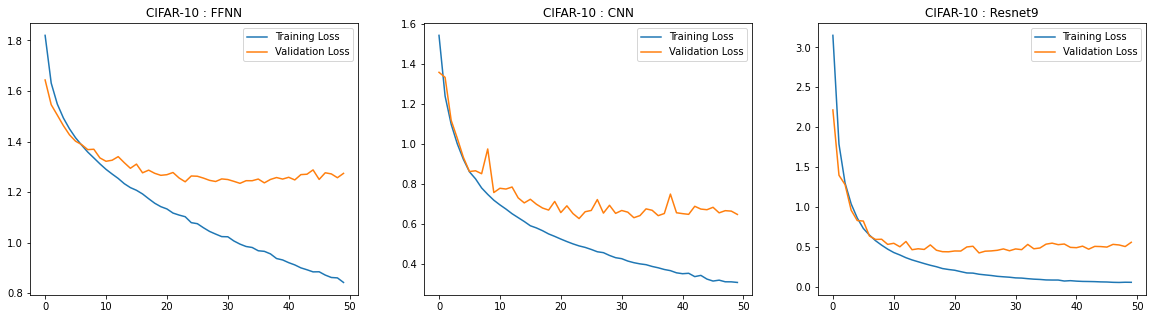

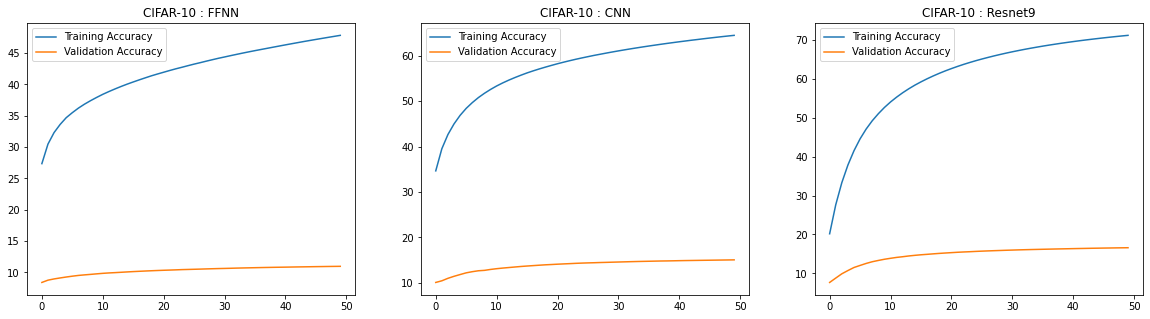

In [34]:
title=['FFNN','CNN','Resnet9']
model_losses=[m1_loss,m2_loss,m3_loss]
model_accs=[m1_acc,m2_acc,m3_acc]

fig=plt.figure(1,figsize=(20,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,3,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('CIFAR-10 : '+title[idx-1])
  idx+=1
  plt.legend();

fig=plt.figure(2,figsize=(20,5))
idx=1
for i in model_accs:
  ax=fig.add_subplot(1,3,idx)
  ax.plot(i['train'],label="Training Accuracy")
  ax.plot(i['valid'],label="Validation Accuracy")
  ax.set_title('CIFAR-10 : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [39]:
def test(model):
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for idx in range(batch_size):
            label = labels[idx]
            class_correct[label] += correct[idx].item()
            class_total[label] += 1
    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {classes[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    # images, labels = dataiter.next()
    images,labels = next(dataiter)

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 15))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        RGBshow(np.squeeze(images[idx]))
        ax.set_title("{}({}) for {}({})".format(classes[preds[idx]],str(preds[idx].item()), classes[labels[idx]],str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FFNN

For FNet :
Test Loss: 1.2264018300175668
Correctly predicted per class : [723.0, 676.0, 475.0, 342.0, 473.0, 415.0, 696.0, 674.0, 680.0, 657.0], Total correctly perdicted : 5811.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 72.3% where 723 of 1000 were predicted correctly
Test Accuracy of class automobile : 67.6% where 676 of 1000 were predicted correctly
Test Accuracy of class bird : 47.5% where 475 of 1000 were predicted correctly
Test Accuracy of class cat : 34.2% where 342 of 1000 were predicted correctly
Test Accuracy of class deer : 47.3% where 473 of 1000 were predicted correctly
Test Accuracy of class dog : 41.5% where 415 of 1000 were predicted correctly
Test Accuracy of class frog : 69.6% where 696 of 1000 were predicted correctly
Test Accuracy of class horse : 67.4% where 674 of 1000 were predicted correctly
Test Accuracy of class ship

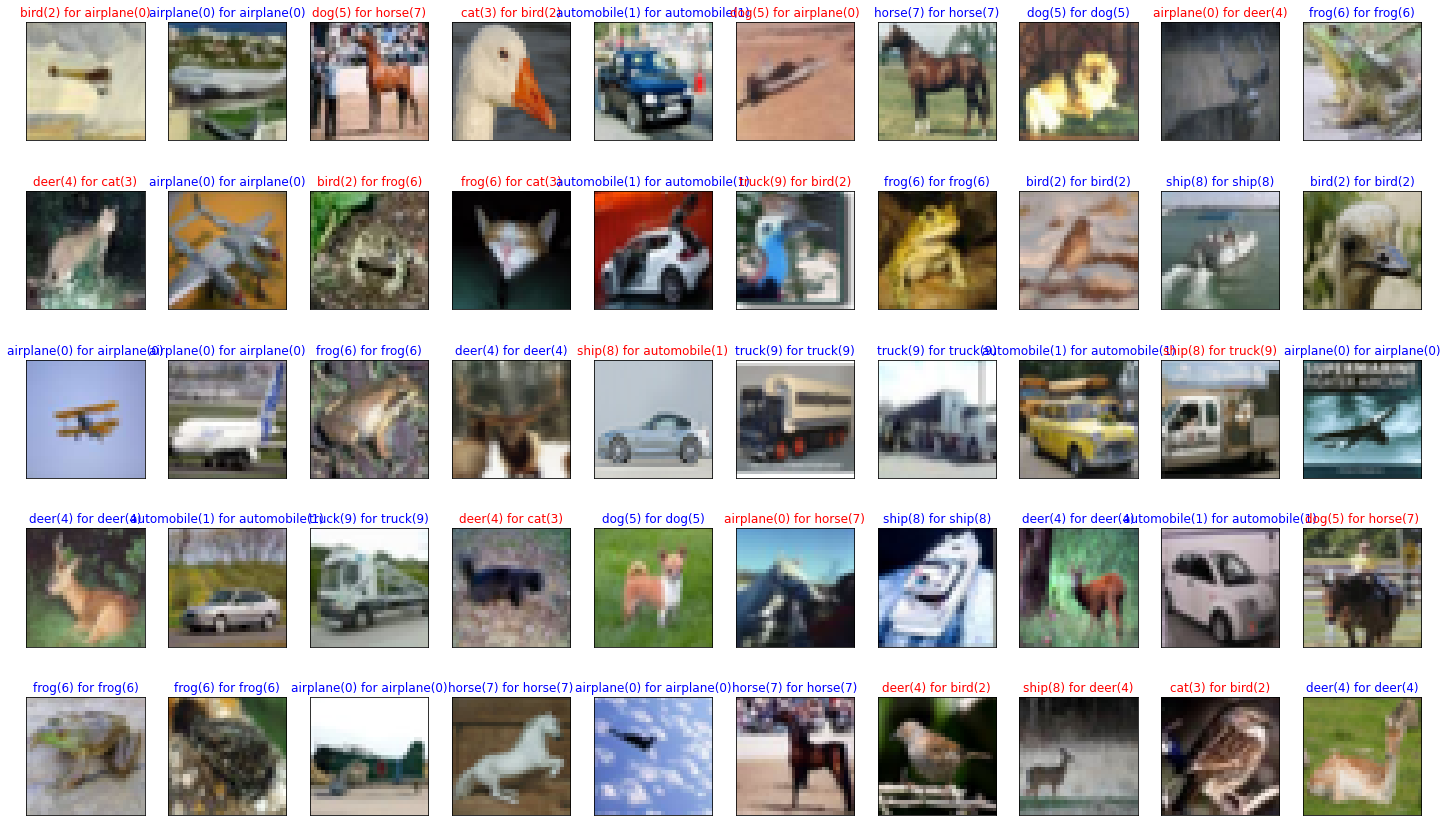

In [40]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.6095319736003876
Correctly predicted per class : [811.0, 914.0, 722.0, 637.0, 757.0, 660.0, 864.0, 874.0, 884.0, 875.0], Total correctly perdicted : 7998.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 81.1% where 811 of 1000 were predicted correctly
Test Accuracy of class automobile : 91.4% where 914 of 1000 were predicted correctly
Test Accuracy of class bird : 72.2% where 722 of 1000 were predicted correctly
Test Accuracy of class cat : 63.7% where 637 of 1000 were predicted correctly
Test Accuracy of class deer : 75.7% where 757 of 1000 were predicted correctly
Test Accuracy of class dog : 66.0% where 660 of 1000 were predicted correctly
Test Accuracy of class frog : 86.4% where 864 of 1000 were predicted correctly
Test Accuracy of class horse : 87.4% where 874 of 1000 were predicted correctly
Test Accuracy of class s

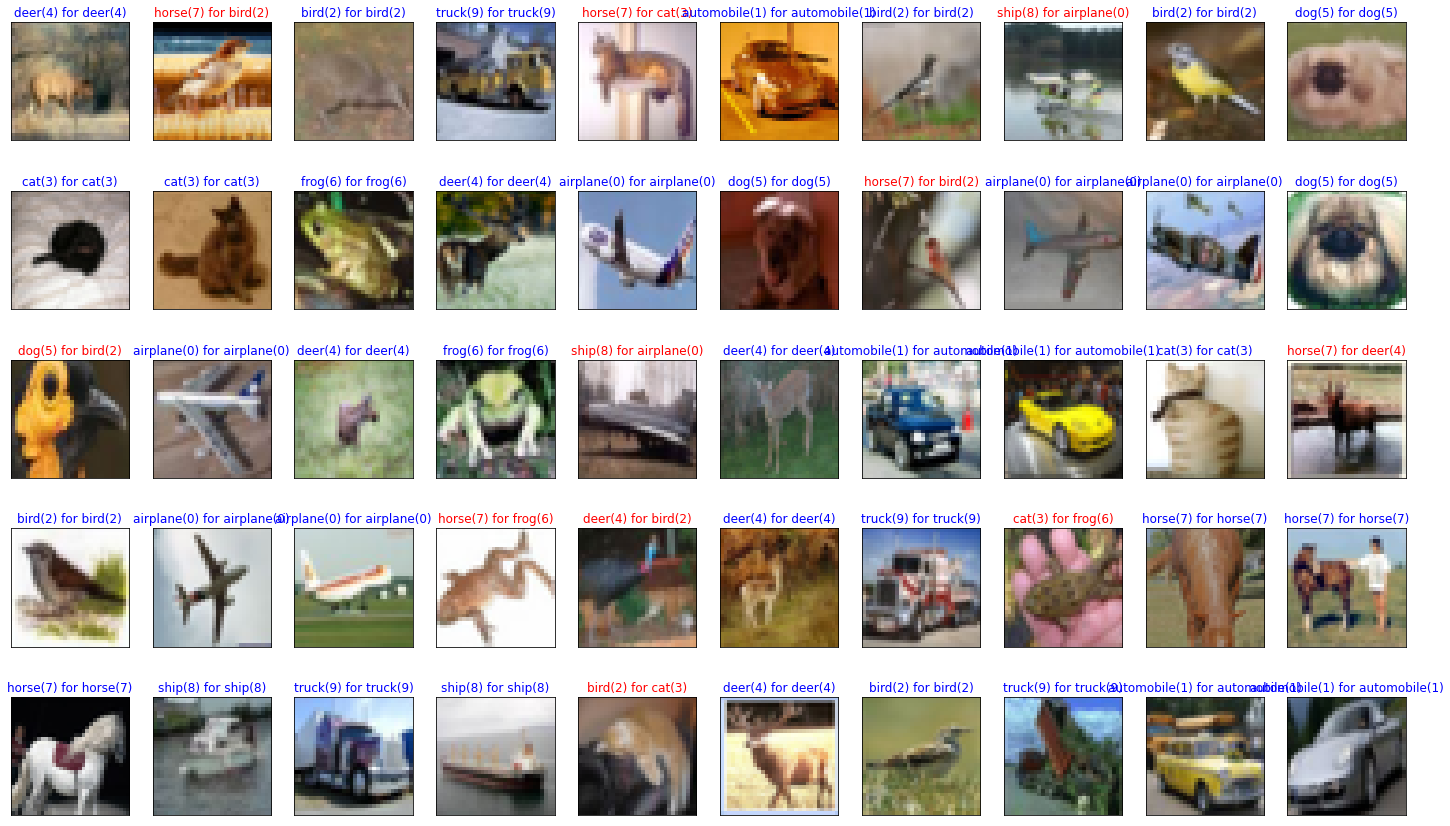

In [41]:
test(model_2)


For ResNet9 :
Test Loss: 0.41181357741355895
Correctly predicted per class : [861.0, 921.0, 854.0, 803.0, 846.0, 829.0, 890.0, 928.0, 956.0, 935.0], Total correctly perdicted : 8823.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 86.1% where 861 of 1000 were predicted correctly
Test Accuracy of class automobile : 92.1% where 921 of 1000 were predicted correctly
Test Accuracy of class bird : 85.4% where 854 of 1000 were predicted correctly
Test Accuracy of class cat : 80.3% where 803 of 1000 were predicted correctly
Test Accuracy of class deer : 84.6% where 846 of 1000 were predicted correctly
Test Accuracy of class dog : 82.9% where 829 of 1000 were predicted correctly
Test Accuracy of class frog : 89.0% where 890 of 1000 were predicted correctly
Test Accuracy of class horse : 92.8% where 928 of 1000 were predicted correctly
Test Accuracy of class 

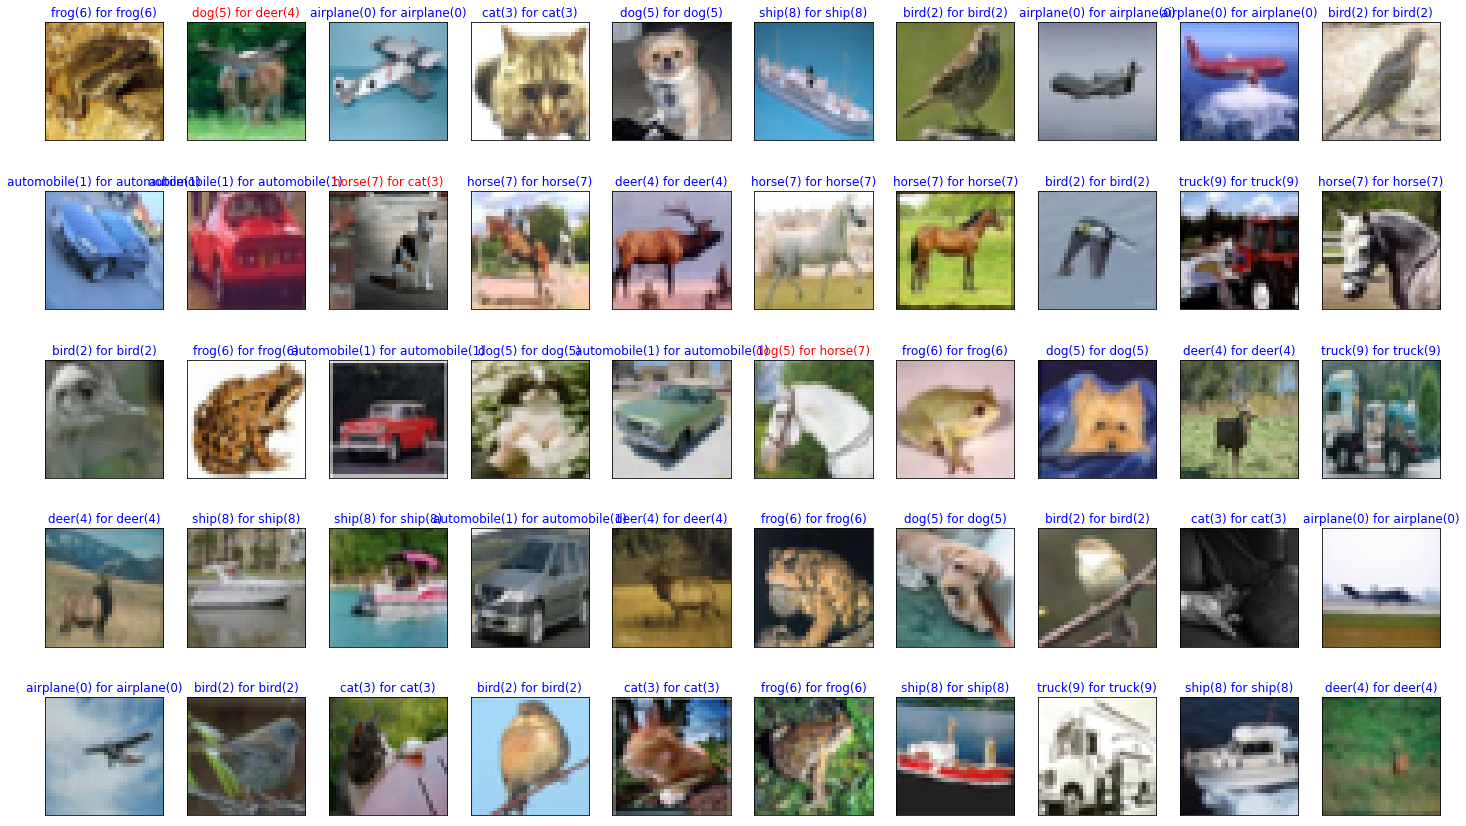

In [42]:
test(model_3)